In [3]:
DATASET = 'full' #'matrix'
OUTNAME = 'SAGE_scales' #'SAGE'
IRT_DATASET = 'scales_' + DATASET
NPERMS = 3
DIFFICULTY_BINS = 10


In [4]:
import sys
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import gc
from sklearn.manifold import TSNE
import seaborn as sns
from cluster_utils import evaluate_items
from vis_utils import (visualize_students, visualize_edges_age, visualize_edges, visualize_items, myresults, FIGSIZE,
CLUSTER_LABELS,  AGE_THR, DPI, CPU_Unpickler, plot_clustering, FONTSCALE)
sns.set_theme(context='talk', style='white', font_scale=FONTSCALE)

FILENAME = f'{OUTNAME}_{DATASET}'
EQUAL_AXES=False
MINSAMPLES = 10 #if DATASET in ['matrix', 'topic'] else 10

RELOAD = False

/home/garben/anaconda3/GNN/lib/python3.8/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: 
 method '__init__' is called recursively. Recursive calls are not supported:
  File "/home/garben/anaconda3/GNN/lib/python3.8/site-packages/torch_sparse/tensor.py", line 26
        trust_data: bool = False,
    ):
        self.storage = SparseStorage(
                       ~~~~~~~~~~~~~ <--- HERE
            row=row,
            rowptr=rowptr,

  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [5]:
FILENAME

'SAGE_scales_full'

In [6]:
torch.cuda.empty_cache()
device = 'cpu'
model = torch.load(f'./results/{FILENAME}.pth.tar', map_location=torch.device('cpu'))

In [7]:
with open(f'./results/{FILENAME}_aux_data.pkl', 'rb') as handle:
    aux_data = CPU_Unpickler(handle).load()
    
(df, df_student, df_item, df_edge, 
            train_losses, #test_losses, test_aucs,
            train_edge_indices, val_edge_indices, test_edge_indices, 
            data, train_data, val_data, test_data,
            unique_scales, unique_domains, unique_matdiff, 
            DATA_FILE) = aux_data
print(df_item.shape)

(35087, 8)


In [8]:
try:
    # if IRT data exists, take item parameters
    with open(f'./results/IRT_{IRT_DATASET}_aux_data_IRT1.pkl', 'rb') as handle:
        aux_data = CPU_Unpickler(handle).load()

    (_, _, df_item_IRT, *_) = aux_data
    df_item = df_item.join(df_item_IRT[['IRT1_difficulty', 'IRT1_discrimination', 'IRT1_discrimination_transf']])
except:
    print('IRT1 not found')


In [9]:
print(df_item.shape)
print(df_item_IRT.shape)

(35087, 11)
(35087, 11)


In [10]:
df_item.head()

,scale,matrix,IRT_difficulty,matdiff,topic,responseformat,textlength,domain,IRT1_difficulty,IRT1_discrimination,IRT1_discrimination_transf
0,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,-1.981765,1.084232,0.671498
1,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,1.103408,0.465689,-0.522373
2,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,-0.399558,0.762680,0.134544
3,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,0.334282,0.832095,0.260923
4,fles,F.2.A.1.b.3,-0.49488,,Berichte,NaN,NaN,f,1.624198,0.971251,0.495456


In [11]:
df_item_IRT.head()

,scale,matrix,IRT_difficulty,matdiff,topic,responseformat,textlength,domain,IRT1_difficulty,IRT1_discrimination,IRT1_discrimination_transf
0,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,-1.981765,1.084232,0.671498
1,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,1.103408,0.465689,-0.522373
2,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,-0.399558,0.762680,0.134544
3,fhoe,F.1.A.1.c.1,-0.37033,,Monologe und Dialoge,NaN,NaN,f,0.334282,0.832095,0.260923
4,fles,F.2.A.1.b.3,-0.49488,,Berichte,NaN,NaN,f,1.624198,0.971251,0.495456


In [12]:
if RELOAD:
    df = load_data_heterogeneous(DATA_FILE)
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1522261


In [14]:
print(data)

HeteroData(
  student={
    node_id=[91677],
    x=[91677, 2],
  },
  item={
    node_id=[35087],
    x=[35087, 11],
  },
  (student, responds, item)={
    edge_index=[2, 33767508],
    edge_attr=[33767508, 2],
    y=[33767508],
  },
  (item, rev_responds, student)={
    edge_index=[2, 33767508],
    y=[33767508],
  }
)


In [15]:
if '_RT_' in OUTNAME:
    
    pars = model(data)
    npars = pars.shape[1]

    if npars == 6:
        tau_s, theta_s, a_s, theta_i, a_i, bias_i = torch.chunk(pars, npars, dim=1)
        print(pars.shape)
        NBINS=100
        fig, ax = plt.subplots(2, 3, figsize=(16, 14))
        ax[0, 0].hist(tau_s.detach().numpy(), bins=NBINS)
        ax[0, 1].hist(theta_s.detach().numpy(), bins=NBINS)
        ax[0, 2].hist(a_s.detach().numpy(), bins=NBINS)
        
        ax[1, 0].hist(theta_i.detach().numpy(), bins=NBINS)
        ax[1, 1].hist(a_i.detach().numpy(), bins=NBINS)
        ax[1, 2].hist(bias_i.detach().numpy(), bins=NBINS)
        
        ax[0, 0].set_title('tau_s')
        ax[0, 1].set_title('theta_s')
        ax[0, 2].set_title('a_s')
        ax[1, 0].set_title('theta_i')
        ax[1, 1].set_title('a_i')
        ax[1, 2].set_title('bias_i')
        
        plt.show()
    else:
        tau_s, theta_s, a_s, tau_i, theta_i, a_i, bias_i = torch.chunk(pars, npars, dim=1)
        print(pars.shape)
        NBINS=100
        fig, ax = plt.subplots(2, 4, figsize=(16, 14))
        ax[0, 0].hist(tau_s.detach().numpy(), bins=NBINS)
        ax[0, 1].hist(theta_s.detach().numpy(), bins=NBINS)
        ax[0, 2].hist(a_s.detach().numpy(), bins=NBINS)
        
        ax[1, 0].hist(tau_i.detach().numpy(), bins=NBINS)
        ax[1, 1].hist(theta_i.detach().numpy(), bins=NBINS)
        ax[1, 2].hist(a_i.detach().numpy(), bins=NBINS)
        ax[1, 3].hist(bias_i.detach().numpy(), bins=NBINS)
        
        ax[0, 0].set_title('tau_s')
        ax[0, 1].set_title('theta_s')
        ax[0, 2].set_title('a_s')
        ax[1, 0].set_title('tau_i')
        ax[1, 1].set_title('theta_i')
        ax[1, 2].set_title('a_i')
        ax[1, 3].set_title('bias_i')
        
        plt.show()
        

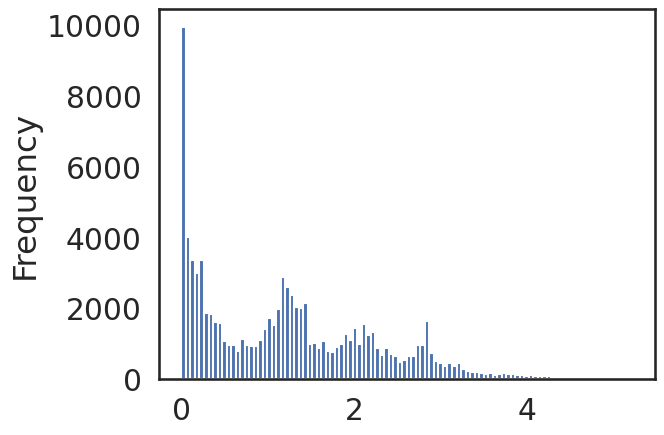

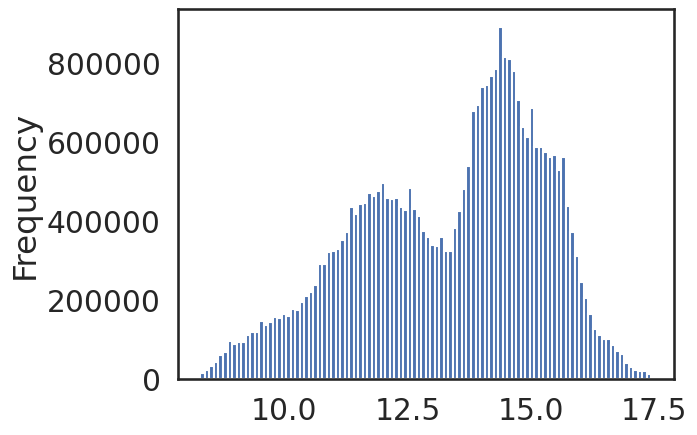

In [16]:
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())
fig = plt.figure()
age_ranges.plot.hist(bins=100)
plt.show()

fig = plt.figure()
df.age.plot.hist(bins=100)
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())

plt.show()

236.0

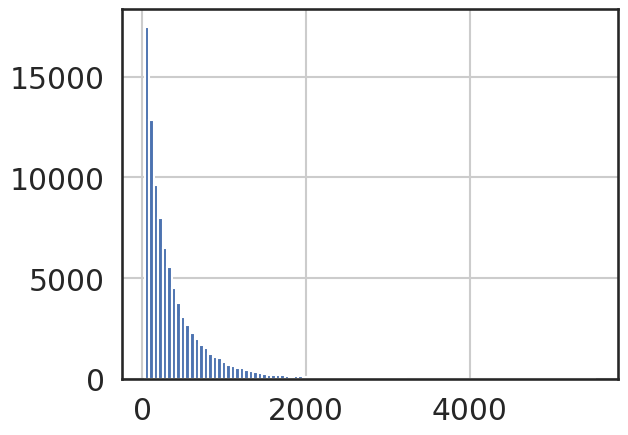

In [17]:
# different items per student
df.groupby(['studentId']).code.nunique().hist(bins=100)
df.groupby(['studentId']).code.nunique().median()


10.0

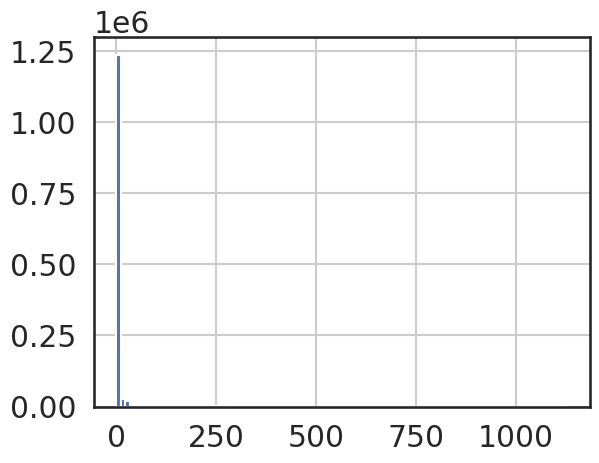

In [18]:
df.groupby(['assessmentId']).code.nunique().hist(bins=100)
df.groupby(['assessmentId']).code.nunique().median()

In [19]:
age_ranges.mean()

1.2189035417825627

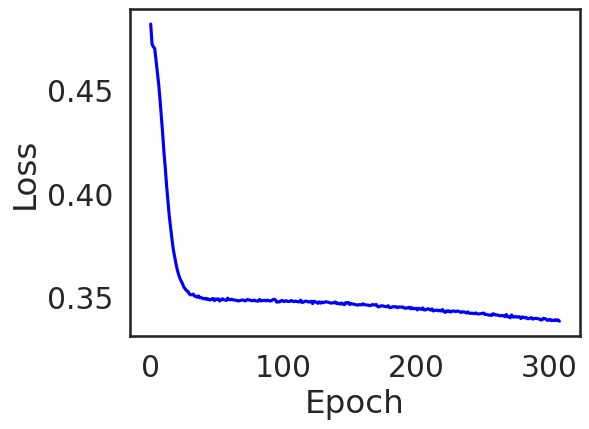

In [20]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_losses.png', dpi=DPI)

In [21]:
df.head()

,index,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,...,school_postcode,canton,school_code,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
1,1,0,1,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
2,2,0,2,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
3,3,0,3,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
4,4,0,4,1.0,0.0,fles,F.2.A.1.b.3,-0.49488,Berichte,NaN,...,4057,Basel-Stadt,04-052,0.657010,2.727266,3,1.10,,,f


df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)

df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


In [22]:
from scipy.stats import pearsonr
dff = df_item[['IRT1_difficulty', 'IRT1_discrimination_transf', 'IRT_difficulty', 'IRT1_discrimination',]].dropna()
print(pearsonr(dff['IRT1_discrimination'], dff['IRT1_discrimination_transf']))
print(pearsonr(dff['IRT1_difficulty'], dff['IRT_difficulty']))

PearsonRResult(statistic=0.9319036067660253, pvalue=0.0)
PearsonRResult(statistic=0.6481655110788012, pvalue=0.0)


plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)


if DATASET in ['matrix', 'topic']:
    sys.exit()

In [23]:
myresults.output_stats()

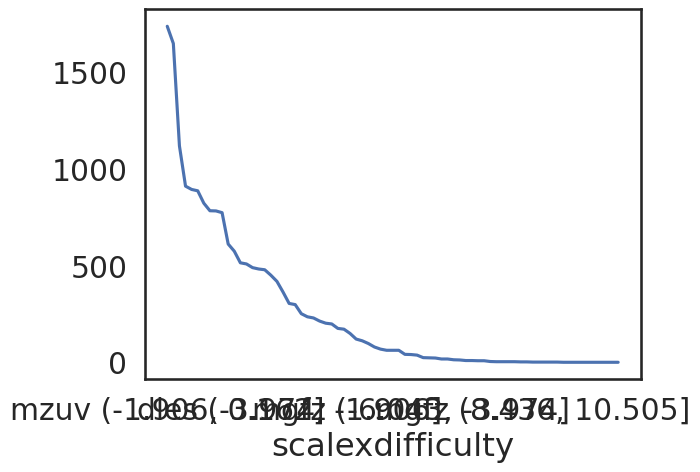

In [24]:
minlevels = 10
#MINSAMPLES = 20
from cluster_utils import compute_clustering_indices
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

dimred = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
#dimred = PCA(whiten=False)

df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


grouping_variable, target_variable = 'scalexdifficulty', 'matrix'
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}
scores = compute_clustering_indices(model, train_data, df_item.copy(), device, grouping_variable, 
                                        target_variable, shuffle=False, seed=0, minsamples=MINSAMPLES)
[ scores_dict[key].append(scores[key]) for key in scores_dict]

scores_df = pd.DataFrame(scores_dict['DB'])        
scores_df = pd.melt(scores_df, value_name='index', var_name=grouping_variable).sort_values('index', ascending=False)

scores_df['N_LEVELS'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_LEVELS'][0][x])
scores_df['N_SAMPLES'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_SAMPLES'][0][x])

scores_df = scores_df.loc[scores_df['N_LEVELS'] >= minlevels]


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=0):
    df_item_ = df_item.reset_index().drop(columns='index')

    df_item_sub = df_item_.loc[df_item_[grouping_variable] == scores_df.iloc[k][grouping_variable]]
    
    # look only at those with a minimum of samples
    tab = df_item_sub[target_variable].value_counts()
    print(tab)
    #ind = tab[tab >= minsamples].index
    ind = tab[:4].index
    df_item_sub = df_item_sub.loc[df_item_sub[target_variable].isin(ind).values]
    if target_variable == 'matrix':
        df_item_sub['labels'] = df_item_sub[target_variable].apply(lambda x: '.'.join(x.split('.')[2:]))
    else:
        df_item_sub['labels'] = df_item_sub[target_variable]
    print(df_item_sub[target_variable].value_counts())
    data = data.to(device)

    z_dict = model.get_embeddings(data, encoded=True)
    embedding = z_dict['item'].detach().cpu().numpy()
    #dimred.fit(embedding)
    #low_dim = dimred.transform(embedding)

    low_dim = dimred.fit_transform(embedding)
    low_dim = low_dim[df_item_sub.index, :]

    X = df_item_sub #.loc[select, :]

    #X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])

    X['x'] = low_dim[:, 0]
    X['y'] = low_dim[:, 1]
     #   X['z'] = low_dim[:, 2]

    fig = plt.figure(figsize=(15, 7))
    axes = sns.scatterplot(data=X, x='x', y='y', hue='labels', s=100, alpha=0.7) 
    axes.legend(prop = { 'size': 16 })
    plt.show()

    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
    clustering.fit(low_dim)

    fig = plt.figure(figsize=(15, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram

    plot_dendrogram(clustering, truncate_mode="level", p=10, labels=df_item_sub['labels'].values)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
#for k in range(4):
#    plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=k)


In [25]:
scores_df


,scalexdifficulty,index,N_LEVELS,N_SAMPLES
20,"esif (-3.974, -1.906]",0.141619,10,213
27,"ehoe (0.162, 2.231]",0.129150,10,214
6,"mzuv (0.162, 2.231]",0.126168,28,629
25,"mfur (0.162, 2.231]",0.120590,27,622
32,"ehoe (-1.906, 0.162]",0.119750,19,431
31,"mzuv (-3.974, -1.906]",0.119713,25,451
39,"mgfz (-3.974, -1.906]",0.116494,18,338
3,"fles (0.162, 2.231]",0.113575,15,389
30,"mgfz (-1.906, 0.162]",0.110048,40,951
24,"mfur (-1.906, 0.162]",0.109979,26,613


# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [ ]:
scores_dict = {
    'matrix':{'CH': [], 'SH': [], 'DB':[]},
    'topic':{'CH': [], 'SH': [], 'DB':[]}
    }
distances_dict = {'within': [], 'between': []}
mean_distance_list = []
#NPERMS = 10
# perm == 0 is unshuffled
for perm in range(NPERMS):
    scores_matrix, scores_topic, within_domain, between_domain, mean_distances, unique_scales, within_between_scales = evaluate_items(model, train_data, df_item, device, 
                                                                           shuffle=perm>0, 
                                                                           seed=0, 
                                                                           minsamples=MINSAMPLES)
    
    [ scores_dict['matrix'][key].append(scores_matrix[key]) for key in scores_dict['matrix']]
    [ scores_dict['topic'][key].append(scores_matrix[key]) for key in scores_dict['topic']]
    distances_dict['within'].append(within_domain)
    distances_dict['between'].append(between_domain)
    mean_distance_list.append(within_between_scales)

In [25]:
distances_df = pd.DataFrame(np.concatenate(mean_distance_list), columns=unique_scales) 
distances_df['perm'] = distances_df.index // len(unique_scales)
distances_df['random'] = 'Observed\n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled\n data'
distances_df['within_between'] = 'between'
distances_df.loc[ distances_df.index % len(unique_scales) == 0, 'within_between'] = 'within'

distances_df = distances_df.groupby(['perm','within_between','random'])[unique_scales].mean().reset_index()
distances_df = pd.melt(distances_df, id_vars=['perm','within_between','random'], value_name='distance', var_name='scale')

# between - within distance should be positive
distances_df['diff'] = distances_df['distance'] 
aux = distances_df.query('`within_between` == "between"').copy().reset_index()
within = distances_df.query('`within_between` == "within"').reset_index()['distance']
aux['diff'] = (aux['diff'] - within)/within*100

distances_df = aux.drop(columns='within_between').sort_values(by=['scale', 'random'])


In [26]:
distances_df.query('perm == 0' )

,index,perm,random,scale,distance,diff
70,140,0,Observed\n data,dles,5.873997,28.856765
30,60,0,Observed\n data,dsif,5.741215,16.049898
90,180,0,Observed\n data,ehoe,5.742074,11.158409
60,120,0,Observed\n data,eles,5.667796,11.947402
40,80,0,Observed\n data,esif,6.272963,-0.318446
0,0,0,Observed\n data,fhoe,6.022266,7.582774
10,20,0,Observed\n data,fles,5.777888,17.557890
50,100,0,Observed\n data,fsif,5.885276,7.044660
80,160,0,Observed\n data,mfur,6.320764,2.495799
100,200,0,Observed\n data,mgfz,6.428890,0.983139


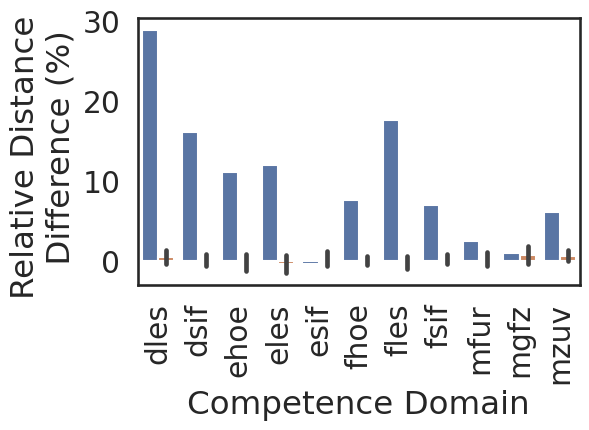

In [27]:
fig = plt.figure()
axes = sns.barplot(data=distances_df, x='scale', y='diff', hue='random', errorbar='sd')
axes.legend_.remove()
axes.tick_params(axis='x', rotation=90)
axes.set(xlabel='Competence Domain', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_scale_distance_bw.png', dpi=DPI)

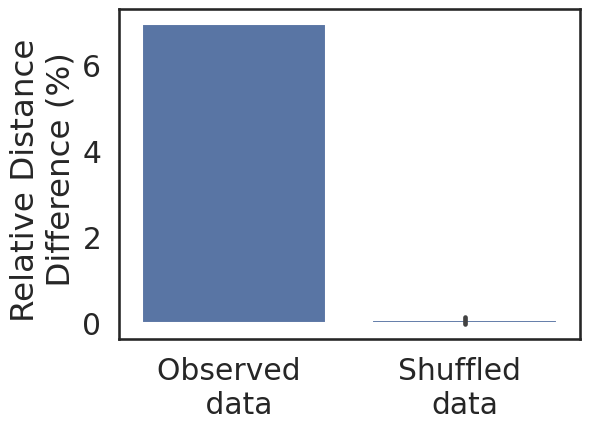

In [28]:
distances_df = pd.DataFrame(distances_dict)
distances_df['perm'] = distances_df.index
#distances_df = pd.melt(distances_df, id_vars='perm', value_name='index', var_name='group')
distances_df['random'] = 'Observed \n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled \ndata'
distances_df['diff'] = (distances_df['between'] - distances_df['within'] )/distances_df['within']*100

fig = plt.figure()
ax = sns.barplot(data=distances_df, x='random', y='diff', errorbar='sd')
ax.set(xlabel='', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()

plt.savefig(f'./vis/{FILENAME}_domain_distance_bw.png', dpi=DPI)

In [29]:
distances_df.query('perm == 0' )

,within,between,perm,random,diff
0,5.646429,6.038812,0,Observed \n data,6.949209


In [30]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#from matplotlib.category import UnitData

for variable in ['matrix']: # , 'topic'
    for i, index in enumerate(['CH', 'DB']): #scores_dict
        fig = plt.figure(figsize=(FIGSIZE))

        scores_df = pd.DataFrame(scores_dict[variable][index])
        scores_df['perm'] = scores_df.index
        scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name='scale')
        scores_df['random'] = 'Observed data'
        scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
        #plt.figure()
        scores_df['scale'] = pd.Categorical(scores_df['scale'], categories=np.sort(scores_df.scale.unique()))
        axes = sns.barplot(data=scores_df, x='scale', y='index', hue='random', errorbar='sd')
        axes.legend_.remove()
        axes.set_xlabel('Competence Domain')
        axes.set_ylabel('Cluster Validity Index')
        axes.set_title(CLUSTER_LABELS[index])
        axes.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.savefig(f'./vis/{FILENAME}_{variable}_bw_random_{index}.png', dpi=DPI)
        plt.close()
        print(scores_df.query('perm == 0'))

     perm scale      index         random
0       0  fhoe   2.644826  Observed data
10      0  fles   4.437299  Observed data
20      0  mzuv  12.880937  Observed data
30      0  dsif  12.473646  Observed data
40      0  esif  17.883933  Observed data
50      0  fsif  13.566500  Observed data
60      0  eles   5.863377  Observed data
70      0  dles   4.820903  Observed data
80      0  mfur  17.417683  Observed data
90      0  ehoe   9.038438  Observed data
100     0  mgfz  13.538758  Observed data
     perm scale     index         random
0       0  fhoe  0.128356  Observed data
10      0  fles  0.088123  Observed data
20      0  mzuv  0.099308  Observed data
30      0  dsif  0.075854  Observed data
40      0  esif  0.092752  Observed data
50      0  fsif  0.101641  Observed data
60      0  eles  0.087280  Observed data
70      0  dles  0.087159  Observed data
80      0  mfur  0.101556  Observed data
90      0  ehoe  0.090730  Observed data
100     0  mgfz  0.102613  Observed data


<Axes: xlabel='scalexdifficulty'>

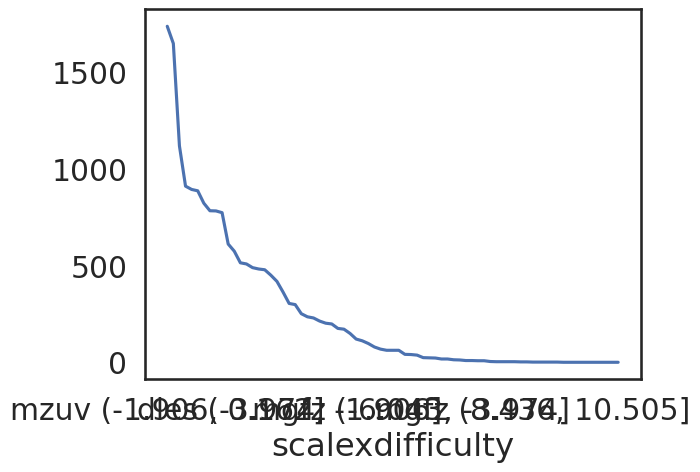

In [31]:
df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' +                                          
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()

In [ ]:
#plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
#                nperms=NPERMS)

%load_ext autoreload
%autoreload 2
from vis_utils import plot_clustering
plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
#if DATASET in ['matrix', 'topic']:
#    sys.exit()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[-0.24473113 -0.18066955  0.16421041  0.18137822 -0.17552292  0.25569612
 -0.25475785 -0.11296371  0.30611163  0.29190132 -0.21934302  0.12451153]
[1.1164765 1.1041014 1.1573448 1.065061  1.1019356 1.1027822 1.0376763
 1.0828503 1.0468881 1.1155539 1.1432635 1.1037894]


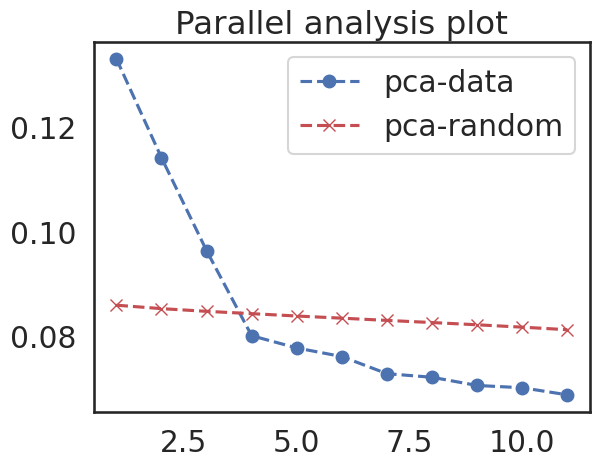

In [ ]:
# represent embeddings before and after the GNN encoder
#%load_ext autoreload
#%autoreload 2
#from vis_utils import visualize_items

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [ ]:
myresults.output_stats()

In [ ]:
#%load_ext autoreload
#%autoreload 2
#from vis_utils import visualize_items
#visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

In [ ]:
FILENAME

In [ ]:
#visualize_students(model, train_data, device, df_student, FILENAME, equal_axes=EQUAL_AXES)

In [ ]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=True, aggregate=True, AGE_THR=AGE_THR)

In [ ]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=False, aggregate=False, AGE_THR=AGE_THR)